# Xiaoxiao ideas - [Issue #4](https://github.com/lucasbaldezzari/babesbayes-nma/issues/4)

**Performance accuracy in relation to reaction time.**
a. Measurement of Angles: Measure the angles between the selected arrow by subjects and the prior motion showed on screen (using the estimated x/y coordinates). We can set up a distribution of the deviation angles from the real orientation to represent the performance index or accuracy. Categorize the deviation angles into specific ranges, such as "0-5 degrees" and "5-10 degrees."

We can consider the following interpretations:

1. **Reaction Time as an Indicator of Attention**: 
2.  **Learning improvement over study session**
3. **Learning Strategy Adjustment**

#### Colaborators
- Xiaoxiao
- Lucas
- *Any other*

---

In [1]:
##importing libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os, requests
from numpy import pi
import seaborn as sns

from utils import getSubjecBasicStats

In [2]:
data = pd.read_csv("dataset\\data01_direction4priors.csv") ##open file

### Working with subject 6

In [3]:
subject_id = 6
data_s6 = data.loc[data['subject_id'] == subject_id]
data_s6.describe()

,trial_index,trial_time,response_arrow_start_angle,motion_direction,motion_coherence,estimate_x,estimate_y,reaction_time,raw_response_time,prior_std,prior_mean,subject_id,experiment_id,session_id,run_id
count,7553.000000,7553.000000,7553.000000,7553.000000,7553.000000,7553.000000,7553.000000,7553.000000,7553.000000,7553.000000,7553.0,7553.0,7553.0,7553.000000,7553.000000
mean,108.661724,309.325031,179.981067,216.992586,0.110936,-1.045612,-0.946761,1.333163,311.954266,46.830399,225.0,6.0,12.0,4.000000,18.007017
std,62.745776,180.027234,104.666585,57.608262,0.063919,1.347272,1.563893,0.359714,180.002593,29.726685,0.0,0.0,0.0,2.000132,10.098316
min,1.000000,0.000000,0.000000,5.000000,0.060000,-2.500000,-2.499999,0.226008,2.154724,10.000000,225.0,6.0,12.0,1.000000,1.000000
25%,54.000000,153.569935,87.000000,205.000000,0.060000,-2.067683,-2.190949,1.051133,156.578177,20.000000,225.0,6.0,12.0,2.000000,9.000000
50%,108.000000,309.394858,181.000000,225.000000,0.120000,-1.483085,-1.583259,1.274959,311.930449,40.000000,225.0,6.0,12.0,4.000000,18.000000
75%,162.000000,463.135354,272.000000,245.000000,0.120000,-0.396685,-0.012798,1.557451,465.658664,80.000000,225.0,6.0,12.0,6.000000,27.000000
max,226.000000,692.979736,359.000000,355.000000,0.240000,2.499999,2.499999,3.542557,695.325845,80.000000,225.0,6.0,12.0,7.000000,35.000000


## 1. Reaction Time as an Indicator of Attention

- Reaction time could represent the level of attention. By comparing reaction time with deviation angles, we can determine if shorter reaction times predict higher performance accuracy.
- Decoding Performance Accuracy: Utilize reaction time data to decode and understand performance accuracy. It tell us whether quicker responses are generally associated with more precise performance.

#### Making ranges from reaction time column

I'will take the *reaction_time* and make a new column with *ranges* of reaction time using $0.1$ sec steps.

In [4]:
ranges = np.arange(0,data_s6.loc[:,"reaction_time"].max(),0.1).round(2)
# print(ranges)
data_s6.loc[:,"reaction_time_range"] = pd.cut(data_s6.loc[:,"reaction_time"], bins=ranges, labels=False)+1

if data_s6.loc[:,'reaction_time_range'].isnull().sum() > 0: ##deleting rows with NaN values
    data_s6 = data_s6.dropna(subset=['reaction_time_range'])

indexes = data_s6.loc[:,'reaction_time_range'].value_counts().sort_index().index.astype(int) #get the sorted index
x_labels = np.round(ranges[indexes],1) #filtering the range values using the sorted indexes

C:\Users\corre\AppData\Local\Temp\ipykernel_7216\661783327.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_s6.loc[:,"reaction_time_range"] = pd.cut(data_s6.loc[:,"reaction_time"], bins=ranges, labels=False)+1


In [5]:
data_s6.loc[:,"reaction_time_range"].describe()

count    7552.000000
mean       13.827860
std         3.601972
min         3.000000
25%        11.000000
50%        13.000000
75%        16.000000
max        30.000000
Name: reaction_time_range, dtype: float64

In [6]:
##add a reaction_time_range_label column to the data_s6 dataframe using the x_labels. Loop through the reaction_time_range column and get the corresponding x_labels value
data_s6.loc[:,"reaction_time_range_label"] = data_s6.loc[:,"reaction_time_range"].apply(lambda x: ranges[int(x)] if x < len(ranges) else 0)

Counting the trials in each range

In [7]:
counts_ranges = data_s6.loc[:,"reaction_time_range"].value_counts()
counts_ranges.index = (x_labels)
counts_ranges

0.3    936
0.6    835
0.7    826
0.8    752
0.9    700
1.0    690
1.1    553
1.2    506
1.3    445
1.4    325
1.5    253
1.6    191
1.7    144
1.8    116
1.9    102
2.0     56
2.1     36
2.2     26
2.3     25
2.4     16
2.5     10
2.6      4
2.7      2
2.8      1
2.9      1
3.0      1
Name: count, dtype: int64

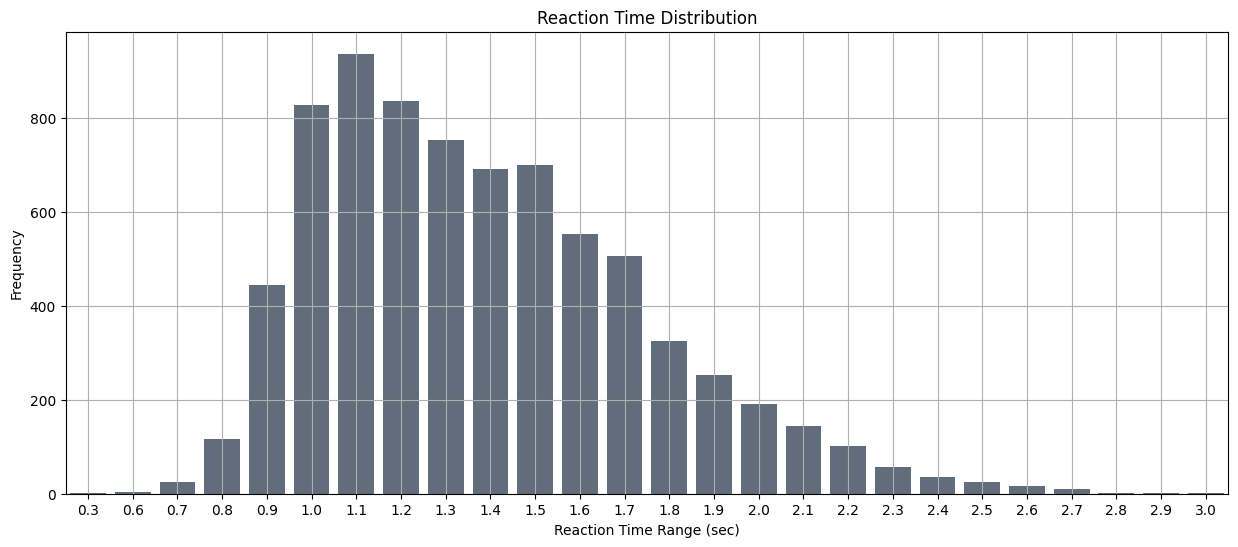

In [8]:
plt.figure(figsize=(15, 6))
sns.countplot(data=data_s6.loc[data_s6['reaction_time_range'].isin(indexes)], x='reaction_time_range', color = "#5D6D7E")
plt.title('Reaction Time Distribution')
plt.xlabel('Reaction Time Range (sec)')
plt.ylabel('Frequency')
plt.xticks(ticks=range(len(x_labels)), labels=x_labels, rotation=0)
plt.grid()
plt.show()

In [28]:
print("Grouping by motion_coherence and get the mean of the reaction_time_range")
data_s6.groupby('motion_coherence')['reaction_time_range_label'].describe()

Grouping by motion_coherence and get the mean of the reaction_time_range


,count,mean,std,min,25%,50%,75%,max
motion_coherence,,,,,,,,
0.06,3674.0,1.358710,0.355290,0.6,1.1,1.3,1.6,2.9
0.12,2611.0,1.379625,0.355685,0.3,1.1,1.3,1.6,2.7
0.24,1267.0,1.459116,0.373175,0.6,1.2,1.4,1.7,3.0


In [88]:
##pivote table with motion coherence and reaction time range
print("Mean values of reaction time for each motion coherence and reaction time range")
means_mc_reactiontime = data_s6.pivot_table(index='motion_coherence', columns='reaction_time_range_label', values='reaction_time', aggfunc='mean')
means_mc_reactiontime.T

Mean values of reaction time for each motion coherence and reaction time range


motion_coherence,0.06,0.12,0.24
reaction_time_range_label,,,
0.3,NaN,0.226008,NaN
0.6,0.594222,0.578423,0.589474
0.7,0.668989,0.671189,0.675715
0.8,0.767809,0.760627,0.750002
0.9,0.859524,0.855907,0.859511
1.0,0.951416,0.953973,0.951584
1.1,1.051303,1.050173,1.051968
1.2,1.148061,1.150972,1.150471
1.3,1.246558,1.247820,1.250416


In [87]:
print("Std values of reaction time for each motion coherence and reaction time range")
std_mc_reactiontime = data_s6.pivot_table(index='motion_coherence', columns='reaction_time_range_label', values='reaction_time', aggfunc='std')
std_mc_reactiontime.T

Std values of reaction time for each motion coherence and reaction time range


motion_coherence,0.06,0.12,0.24
reaction_time_range_label,,,
0.6,0.005928,NaN,NaN
0.7,0.022012,0.020451,0.008424
0.8,0.024583,0.023232,0.030220
0.9,0.026944,0.025939,0.029242
1.0,0.030346,0.029179,0.028617
1.1,0.028484,0.028245,0.031271
1.2,0.028205,0.029202,0.027974
1.3,0.028589,0.028303,0.031076
1.4,0.028217,0.029256,0.027090


In [89]:
print("Std values of reaction time for each motion coherence and reaction time range")
median_mc_reactiontime = data_s6.pivot_table(index='motion_coherence', columns='reaction_time_range_label', values='reaction_time', aggfunc='median')
median_mc_reactiontime.T

Std values of reaction time for each motion coherence and reaction time range


motion_coherence,0.06,0.12,0.24
reaction_time_range_label,,,
0.3,NaN,0.226008,NaN
0.6,0.594222,0.578423,0.589474
0.7,0.674649,0.673809,0.675715
0.8,0.773320,0.761303,0.748103
0.9,0.865652,0.857898,0.866253
1.0,0.950348,0.956337,0.953240
1.1,1.051203,1.049565,1.055663
1.2,1.146868,1.151074,1.149233
1.3,1.242560,1.245871,1.250386


#### Kernel density estimation

Some plots using [*Kernel density estimation*](https://seaborn.pydata.org/tutorial/distributions.html#kernel-density-estimation) (KDE) from Seaborn.

> A histogram aims to approximate the underlying probability density function that generated the data by binning and counting observations. Kernel density estimation (KDE) presents a different solution to the same problem. Rather than using discrete bins, a KDE plot smooths the observations with a Gaussian kernel, producing a continuous density estimate:

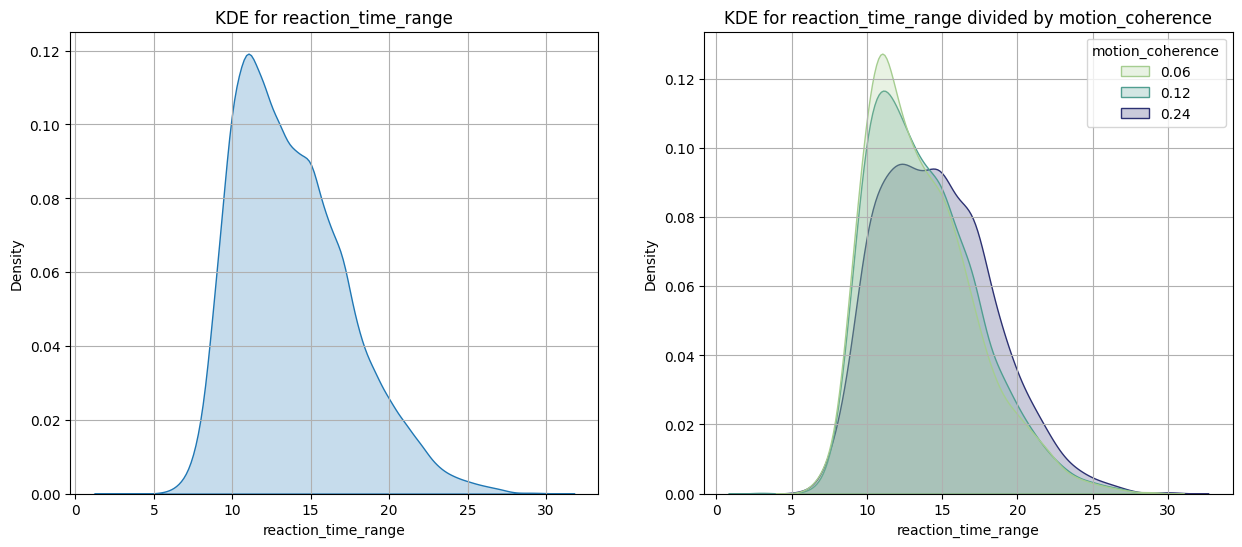

In [9]:
fig, axs = plt.subplots(1,2,figsize=(15, 6))
sns.kdeplot(data=data_s6.loc[data_s6['reaction_time_range'].isin(indexes)], x='reaction_time_range',
            fill=True,common_norm=False,ax=axs[0],bw_adjust=1)
sns.kdeplot(data=data_s6.loc[data_s6['reaction_time_range'].isin(indexes)], x='reaction_time_range', hue = "motion_coherence",
            fill=True,common_norm=False, palette="crest",ax=axs[1])
axs[0].set_title("KDE for reaction_time_range")
axs[1].set_title("KDE for reaction_time_range divided by motion_coherence")
axs[0].grid()
axs[1].grid()
plt.show()

#### Getting angles from $x$ and $y$ coordinates

In [10]:
from utils import getAngles
x = data_s6['estimate_x'].values
y = data_s6['estimate_y'].values
##using estimate_x and estimate_y to calculate the angle
data_s6.loc[:,'estimate_angles'] = np.round(getAngles(x, y), 3)
##limit the angles between 0 and 359 using %360
data_s6.loc[:,'estimate_angles'] = data_s6['estimate_angles'] % 360

#### Getting difference between *motion_direction* and *estimate_angles*

In [11]:
data_s6.loc[:,'diff_angles'] = data_s6['motion_direction'] - data_s6['estimate_angles']
data_s6.loc[:,'diff_angles'].describe()

count    7552.000000
mean        9.942208
std        67.727010
min      -354.278000
25%       -18.125000
50%         1.501000
75%        22.630000
max       353.722000
Name: diff_angles, dtype: float64

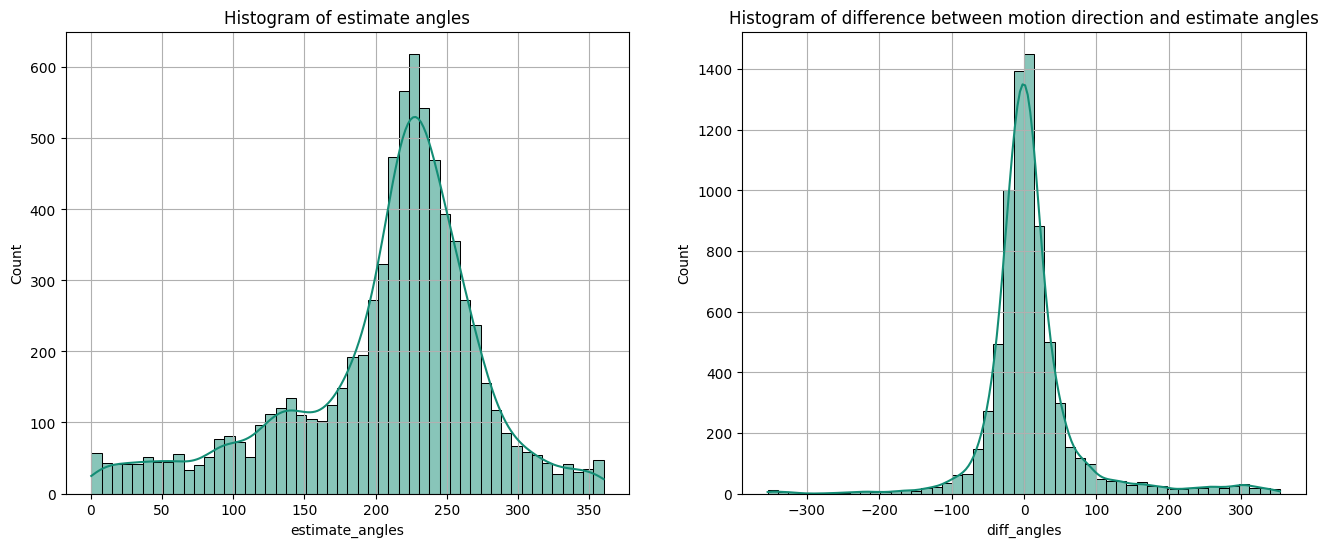

In [12]:
fig, axs = plt.subplots(1,2,figsize=(16, 6))
sns.histplot(data_s6['estimate_angles'], bins=50, kde=True, color='#138D75', alpha=0.5, ax=axs[0])
sns.histplot(data_s6['diff_angles'], bins=50, kde=True, color='#138D75', alpha=0.5, ax=axs[1])
axs[0].set_title("Histogram of estimate angles")
axs[1].set_title("Histogram of difference between motion direction and estimate angles")
axs[0].grid()
axs[1].grid()
plt.show()

In [13]:
# fig, axs = plt.subplots(1,2,figsize=(16, 6))
# sns.histplot(data_s6,x="estimate_angles", bins=50, kde=True, palette="Set2", alpha=0.5, ax=axs[0], hue="reaction_time_range")
# sns.histplot(data_s6['diff_angles'], bins=50, kde=True, color='#138D75', alpha=0.5, ax=axs[1])
# axs[0].set_title("Histogram of estimate angles")
# axs[1].set_title("Histogram of difference between motion direction and estimate angles")
# axs[0].grid()
# axs[1].grid()
# ##turn off legend
# axs[0].get_legend().remove()
# plt.show()

#### [Bivariate plots](https://seaborn.pydata.org/tutorial/distributions.html#visualizing-bivariate-distributions)

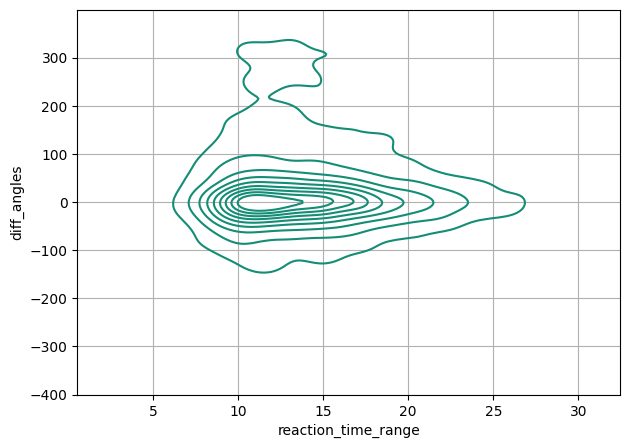

In [14]:
plt.figure(figsize=(7,5))
sns.kdeplot(data=data_s6, x="reaction_time_range", y="diff_angles", color="#138D75")
plt.grid()
plt.show()

#### [Pairplots](https://seaborn.pydata.org/generated/seaborn.pairplot.html#seaborn-pairplot)

c:\Users\corre\miniconda3\envs\pda\Lib\site-packages\seaborn\axisgrid.py:2100: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


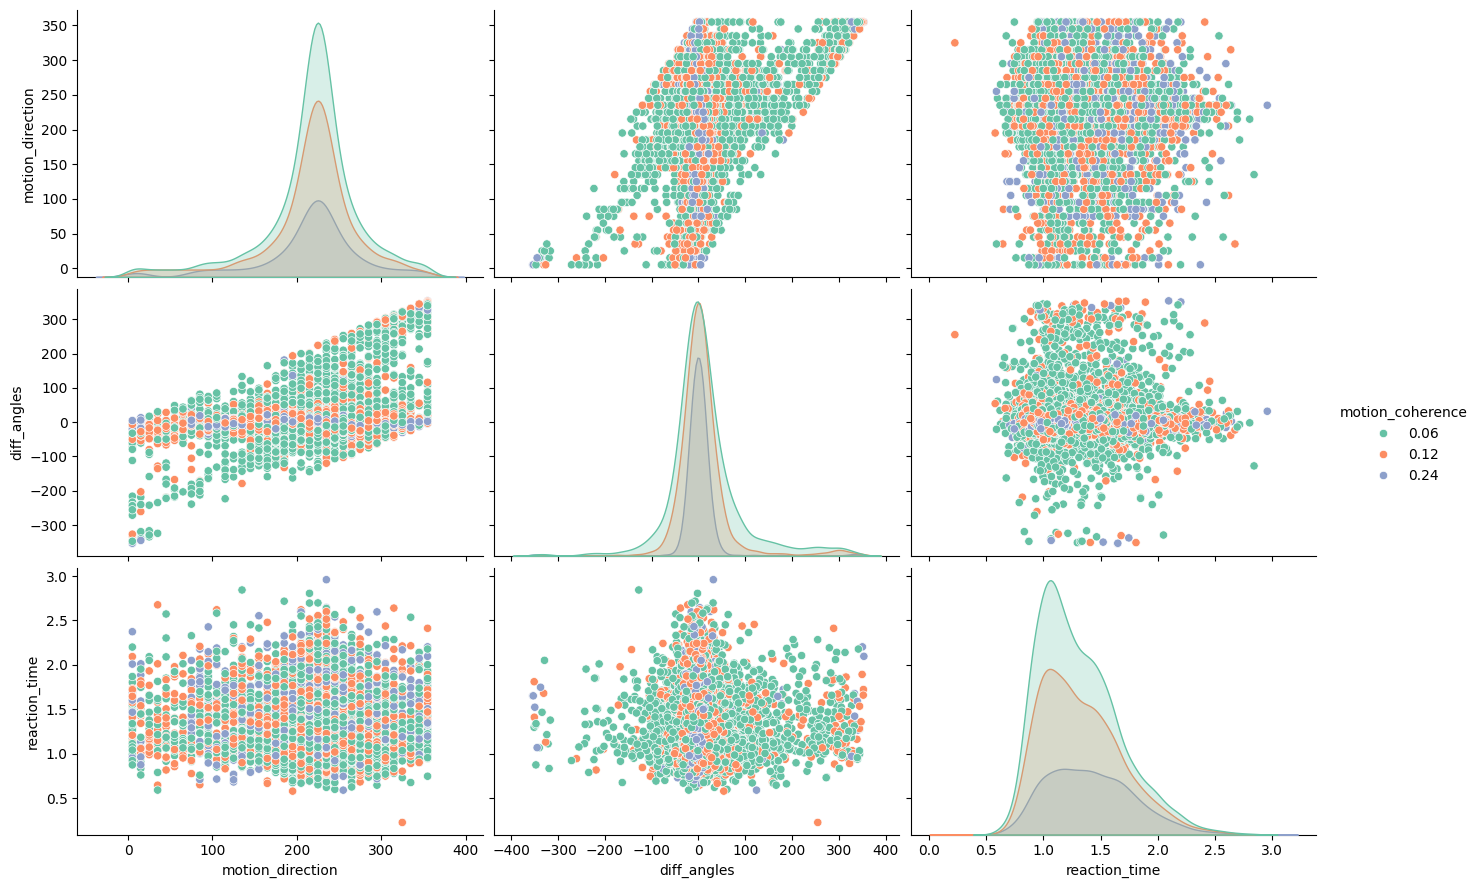

In [21]:
cols_interest = ["motion_direction","diff_angles","reaction_time","motion_coherence"]
g = sns.pairplot(data_s6.loc[:,cols_interest].iloc[:],size = 3, aspect=1.5, hue = "motion_coherence",palette="Set2",)
# g.map_lower(sns.kdeplot, levels=10, color=".2")
# g.map_upper(sns.kdeplot, levels=10, color=".2")
plt.show()

c:\Users\corre\miniconda3\envs\pda\Lib\site-packages\seaborn\axisgrid.py:2100: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


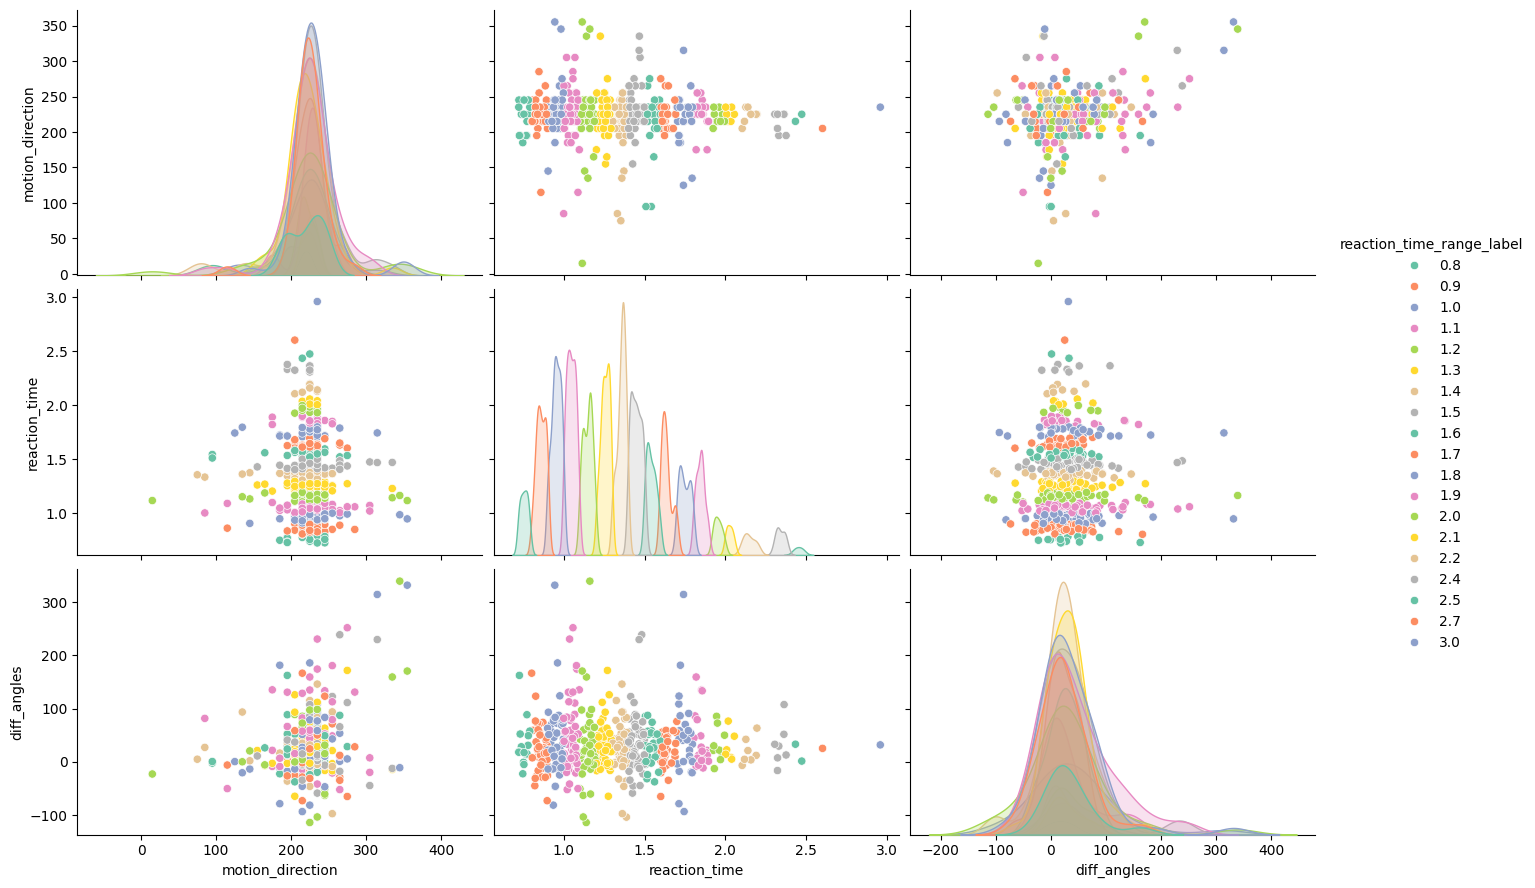

In [17]:
cols_interest = ["motion_direction","reaction_time_range_label","reaction_time","diff_angles"]
g = sns.pairplot(data_s6.loc[:,cols_interest].iloc[:500], hue = "reaction_time_range_label",  palette="Set2",size = 3, aspect=1.5)
# g.map_lower(sns.kdeplot, levels=10, color=".2")
# g.map_upper(sns.kdeplot, levels=10, color=".2")
plt.show()

In [70]:
data_s6.columns

Index(['trial_index', 'trial_time', 'response_arrow_start_angle',
       'motion_direction', 'motion_coherence', 'estimate_x', 'estimate_y',
       'reaction_time', 'raw_response_time', 'prior_std', 'prior_mean',
       'subject_id', 'experiment_name', 'experiment_id', 'session_id',
       'run_id', 'reaction_time_range', 'reaction_time_range_label',
       'estimate_angles', 'diff_angles'],
      dtype='object')